In [55]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM


import src.lstm_helper as lh
import src.time_series_helpers as th

In [3]:
#reference:https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# https://heartbeat.fritz.ai/building-a-neural-network-from-scratch-using-python-part-1-6d399df8d432
# https://www.kaggle.com/alexdance/store-item-combination-part-6-deep-learning
# https://www.tensorflow.org/tutorials/structured_data/time_series

### Predict future sales but non time-series models.

#### Fearture engineering

In [9]:
#load dataset that is processed by store by item
path = 'data/store_item.csv'
df = pd.read_csv(path)
df.shape

(1826, 501)

In [10]:
#set datatime to index
df['date'] =  pd.to_datetime(df['date'])
df = df.set_index('date')

#### Build a  Single-output model
Single-output, multi-time-step predictions

In [11]:
# extract columns names
columns = df.columns.tolist()
columns[:5]

['s1_i1', 's1_i2', 's1_i3', 's1_i4', 's1_i5']

In [12]:
# try to predict 1 year sales of item 1 at store 1
output_cols = columns[:1]

def prepare_data(df,output_cols):
    #load item 1 at store 1 sales values
    prep_df = df[output_cols]
    # convert df_1 to a dataframe
    prep_df = pd.DataFrame(prep_df)
    return prep_df

prep_df = prepare_data(df,output_cols)
prep_df.shape

(1826, 1)

In [13]:
prep_df.head()

,s1_i1
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


#### Predict  3 months sales by one store-item ( store 1, item1)

In [14]:
# split into training, validation, and test sets.

output_length =92 # the number days we would like to predict
#time_stepts in LSTM: the recurrent cell gets unrolled to a specified length 
time_steps = 14    #recurrent cell numbers,two weeks

train_size = prep_df.shape[0] - (output_length+time_steps)
test_size  = prep_df.shape[0] - train_size
train = prep_df.iloc[:train_size,:]
test  = prep_df.iloc[-test_size:,:]
valid = prep_df.iloc[-output_length:,:]

In [15]:
print('All shapes are:    (train, ,test,valid)')
print(f'train dataset shape: {train.shape}')
print(f'test dataset shape: {test.shape}')
print(f'valid dataset shape: {valid.shape}')


All shapes are:    (train, ,test,valid)
train dataset shape: (1720, 1)
test dataset shape: (106, 1)
valid dataset shape: (92, 1)


In [16]:
# Genarate window datasets
# One of the most difficult parts of Deep Learning modelling is to get the dataset in the right format 
# The function completes that process
X_train, y_train = lh.window_generator(train, train.iloc[:,:len(output_cols)],time_steps)
X_test,  y_test  = lh.window_generator(test, test.iloc[:,:len(output_cols)],time_steps)


In [17]:
print('All shapes are: (X_train, y_train, X_test,  y_test)')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test  shape: {X_test.shape}')
print(f'y_test  shape: {y_test.shape}')

All shapes are: (X_train, y_train, X_test,  y_test)
X_train shape: (1706, 14, 1)
y_train shape: (1706, 1)
X_test  shape: (92, 14, 1)
y_test  shape: (92, 1)


In [21]:
# call lstm model
lstm_units =128
model_1 = lh.lstm_model(X_train,lstm_units)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
history = model_1.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False)

Train on 1535 samples, validate on 171 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
1535/1535 [==============================] - 4s 3ms/sample - loss: 137.4803 - val_loss: 99.0041
Epoch 2/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 43.2584 - val_loss: 71.0013
Epoch 3/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 43.1666 - val_loss: 61.8116
Epoch 4/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 42.7792 - val_loss: 60.6347
Epoch 5/30
1535/1535 [==============================] - 2s 2ms/sample - loss: 41.5647 - val_loss: 58.7731
Epoch 6/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 40.4901 - val_loss: 56.1643
Epoch 7/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 39.5718 - val_loss: 55.0308
Epoch 8/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 39.2346 - val_loss: 55.9270
Epoch 9/30

In [23]:
y_pred = model_1.predict(X_test)
y_pred.shape

(92, 1)

In [24]:
type(y_pred)

numpy.ndarray

In [26]:
df_forecast = pd.DataFrame(y_pred, index=valid.index, columns=valid.columns + '_forecast')
df_forecast

,s1_i1_forecast
date,
2017-10-01,24.829557
2017-10-02,22.394403
2017-10-03,18.377756
2017-10-04,17.657282
2017-10-05,16.753912
...,...
2017-12-27,14.922359
2017-12-28,14.635464
2017-12-29,15.595961


In [27]:
RMSE  = th.rmse_calculate(df_forecast,valid)
print(RMSE)

5.33


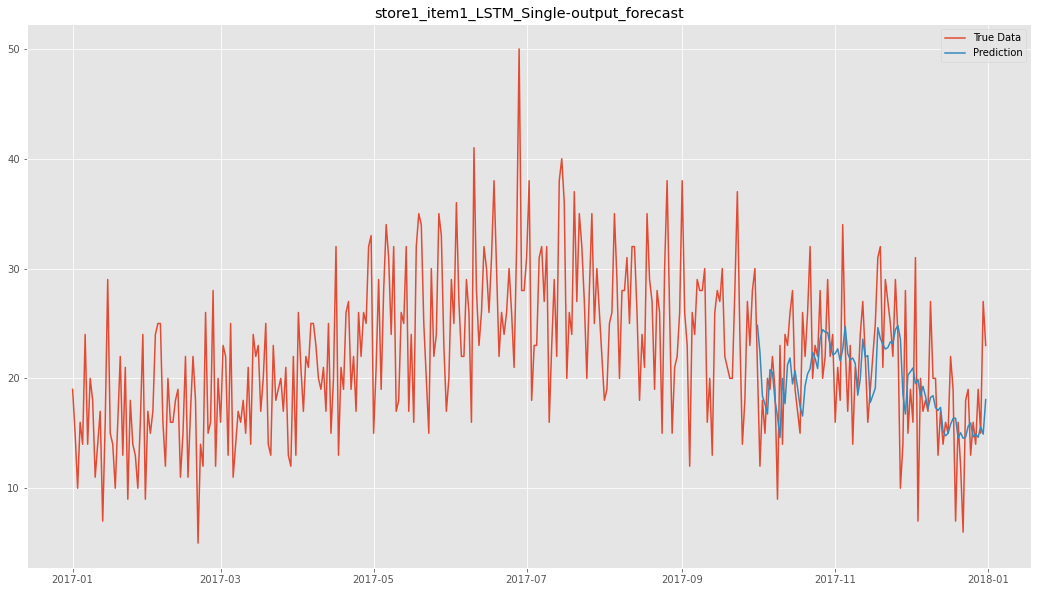

Plot saved.


In [29]:
#plot forecast VS actuals

figtitle = 'store1_item1_LSTM_Single-output_forecast'
th.plot_results(df_forecast, prep_df['2017-1-1':], figtitle)



## Build a  multi-output predictions
multi-output predictions.

### 10 output

In [30]:
# predict 3 months sales for 10 store-item 

In [32]:
# sampling=random.choices(np.arange(df.shape[1]), k=10)
sampling =np.arange(10)
sampling

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [33]:
df_10 = df.iloc[:,sampling]
df_10.head()

,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,s1_i10
date,,,,,,,,,,
2013-01-01,13,33,15,10,11,31,25,33,18,37
2013-01-02,11,43,30,11,6,36,23,37,23,34
2013-01-03,14,23,14,8,8,18,34,38,25,32
2013-01-04,13,18,10,19,9,19,36,54,22,45
2013-01-05,10,34,23,12,8,31,38,51,29,35


In [34]:
# split into training, validation, and test sets.
output_cols = df_10.columns.tolist()
output_length =92 # the number days we would like to predict
#time_stepts in LSTM: the recurrent cell gets unrolled to a specified length 
time_steps = 14    #recurrent cell numbers,two weeks

train,test,valid = lh.split_data(df_10,output_length, time_steps)

In [35]:
print('All shapes are:    (train, ,test, valid,labels)')
print(f'train dataset shape: {train.shape}')
print(f'test dataset shape : {test.shape}')
print(f'valid dataset shape: {valid.shape}')
print(f'labels width       : {len(output_cols)}')

All shapes are:    (train, ,test, valid,labels)
train dataset shape: (1720, 10)
test dataset shape : (106, 10)
valid dataset shape: (92, 10)
labels width       : 10


In [36]:
# Genarate window datasets
# One of the most difficult parts of Deep Learning modelling is to get the dataset in the right format 
# The function completes that process
X_train, y_train = lh.window_generator(train, train.iloc[:,:len(output_cols)],time_steps)
X_test,  y_test  = lh.window_generator(test, test.iloc[:,:len(output_cols)],time_steps)

print('All shapes are: (X_train, y_train, X_test,  y_test)')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test  shape: {X_test.shape}')
print(f'y_test  shape: {y_test.shape}')

All shapes are: (X_train, y_train, X_test,  y_test)
X_train shape: (1706, 14, 10)
y_train shape: (1706, 10)
X_test  shape: (92, 14, 10)
y_test  shape: (92, 10)


In [61]:
# call lstm model
lstm_units = 128*2
model = Sequential()
model.add(LSTM(
            units = lstm_units,
            input_shape=(X_train.shape[1], X_train.shape[2]),
            return_sequences=False
            ))
model.add(Activation("tanh"))
model.add(Dropout(0.2))

model.add(Dense(units=X_train.shape[2]*3))
model.add(Dense(units=X_train.shape[2]))
model.compile(
                loss='mse',
                optimizer="rmsprop") 

In [68]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=30,
    validation_split=0.1,
    verbose=1,
    shuffle=False)

Train on 1535 samples, validate on 171 samples
Epoch 1/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 97.0067 - val_loss: 194.2314
Epoch 2/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 92.1310 - val_loss: 200.0430
Epoch 3/30
1535/1535 [==============================] - 4s 3ms/sample - loss: 94.8531 - val_loss: 193.2749
Epoch 4/30
1535/1535 [==============================] - 5s 3ms/sample - loss: 94.1306 - val_loss: 222.3216
Epoch 5/30
1535/1535 [==============================] - 4s 2ms/sample - loss: 93.1926 - val_loss: 235.1702
Epoch 6/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 93.1915 - val_loss: 261.9762
Epoch 7/30
1535/1535 [==============================] - 5s 3ms/sample - loss: 93.9927 - val_loss: 208.2128
Epoch 8/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 90.9860 - val_loss: 237.9024
Epoch 9/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 92.3247 - val_loss:

In [64]:
y_pred = model.predict(X_test)
y_pred.shape

(92, 10)

In [65]:
df_forecast = pd.DataFrame(y_pred, index=valid.index, columns=valid.columns + '_forecast')
df_forecast

,s1_i1_forecast,s1_i2_forecast,s1_i3_forecast,s1_i4_forecast,s1_i5_forecast,s1_i6_forecast,s1_i7_forecast,s1_i8_forecast,s1_i9_forecast,s1_i10_forecast
date,,,,,,,,,,
2017-10-01,24.757866,63.936520,40.313171,24.378351,20.512005,64.858101,63.951206,83.603279,56.732880,80.496162
2017-10-02,23.961582,62.315487,39.491768,23.738079,19.916813,63.224438,62.294109,81.609962,55.457275,78.470642
2017-10-03,21.931791,56.629627,35.601540,21.549202,18.073486,57.609058,56.599560,74.272438,50.179771,71.294228
2017-10-04,22.399481,58.012798,36.584175,21.891394,18.538488,58.974506,58.000446,75.901962,51.392948,73.133209
2017-10-05,23.034693,60.402733,38.000618,23.031979,19.208160,61.112206,60.175102,78.919624,53.559933,75.759872
...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.092270,49.262180,30.823360,18.829573,15.666961,50.358765,49.253548,65.121910,43.639740,62.052631
2017-12-28,19.912710,51.654766,32.244957,19.689888,16.495981,52.725163,51.528778,67.745880,45.604504,64.800377
2017-12-29,19.339151,50.770222,31.908171,19.248867,16.113495,51.710171,50.703930,66.930450,45.149704,63.923920


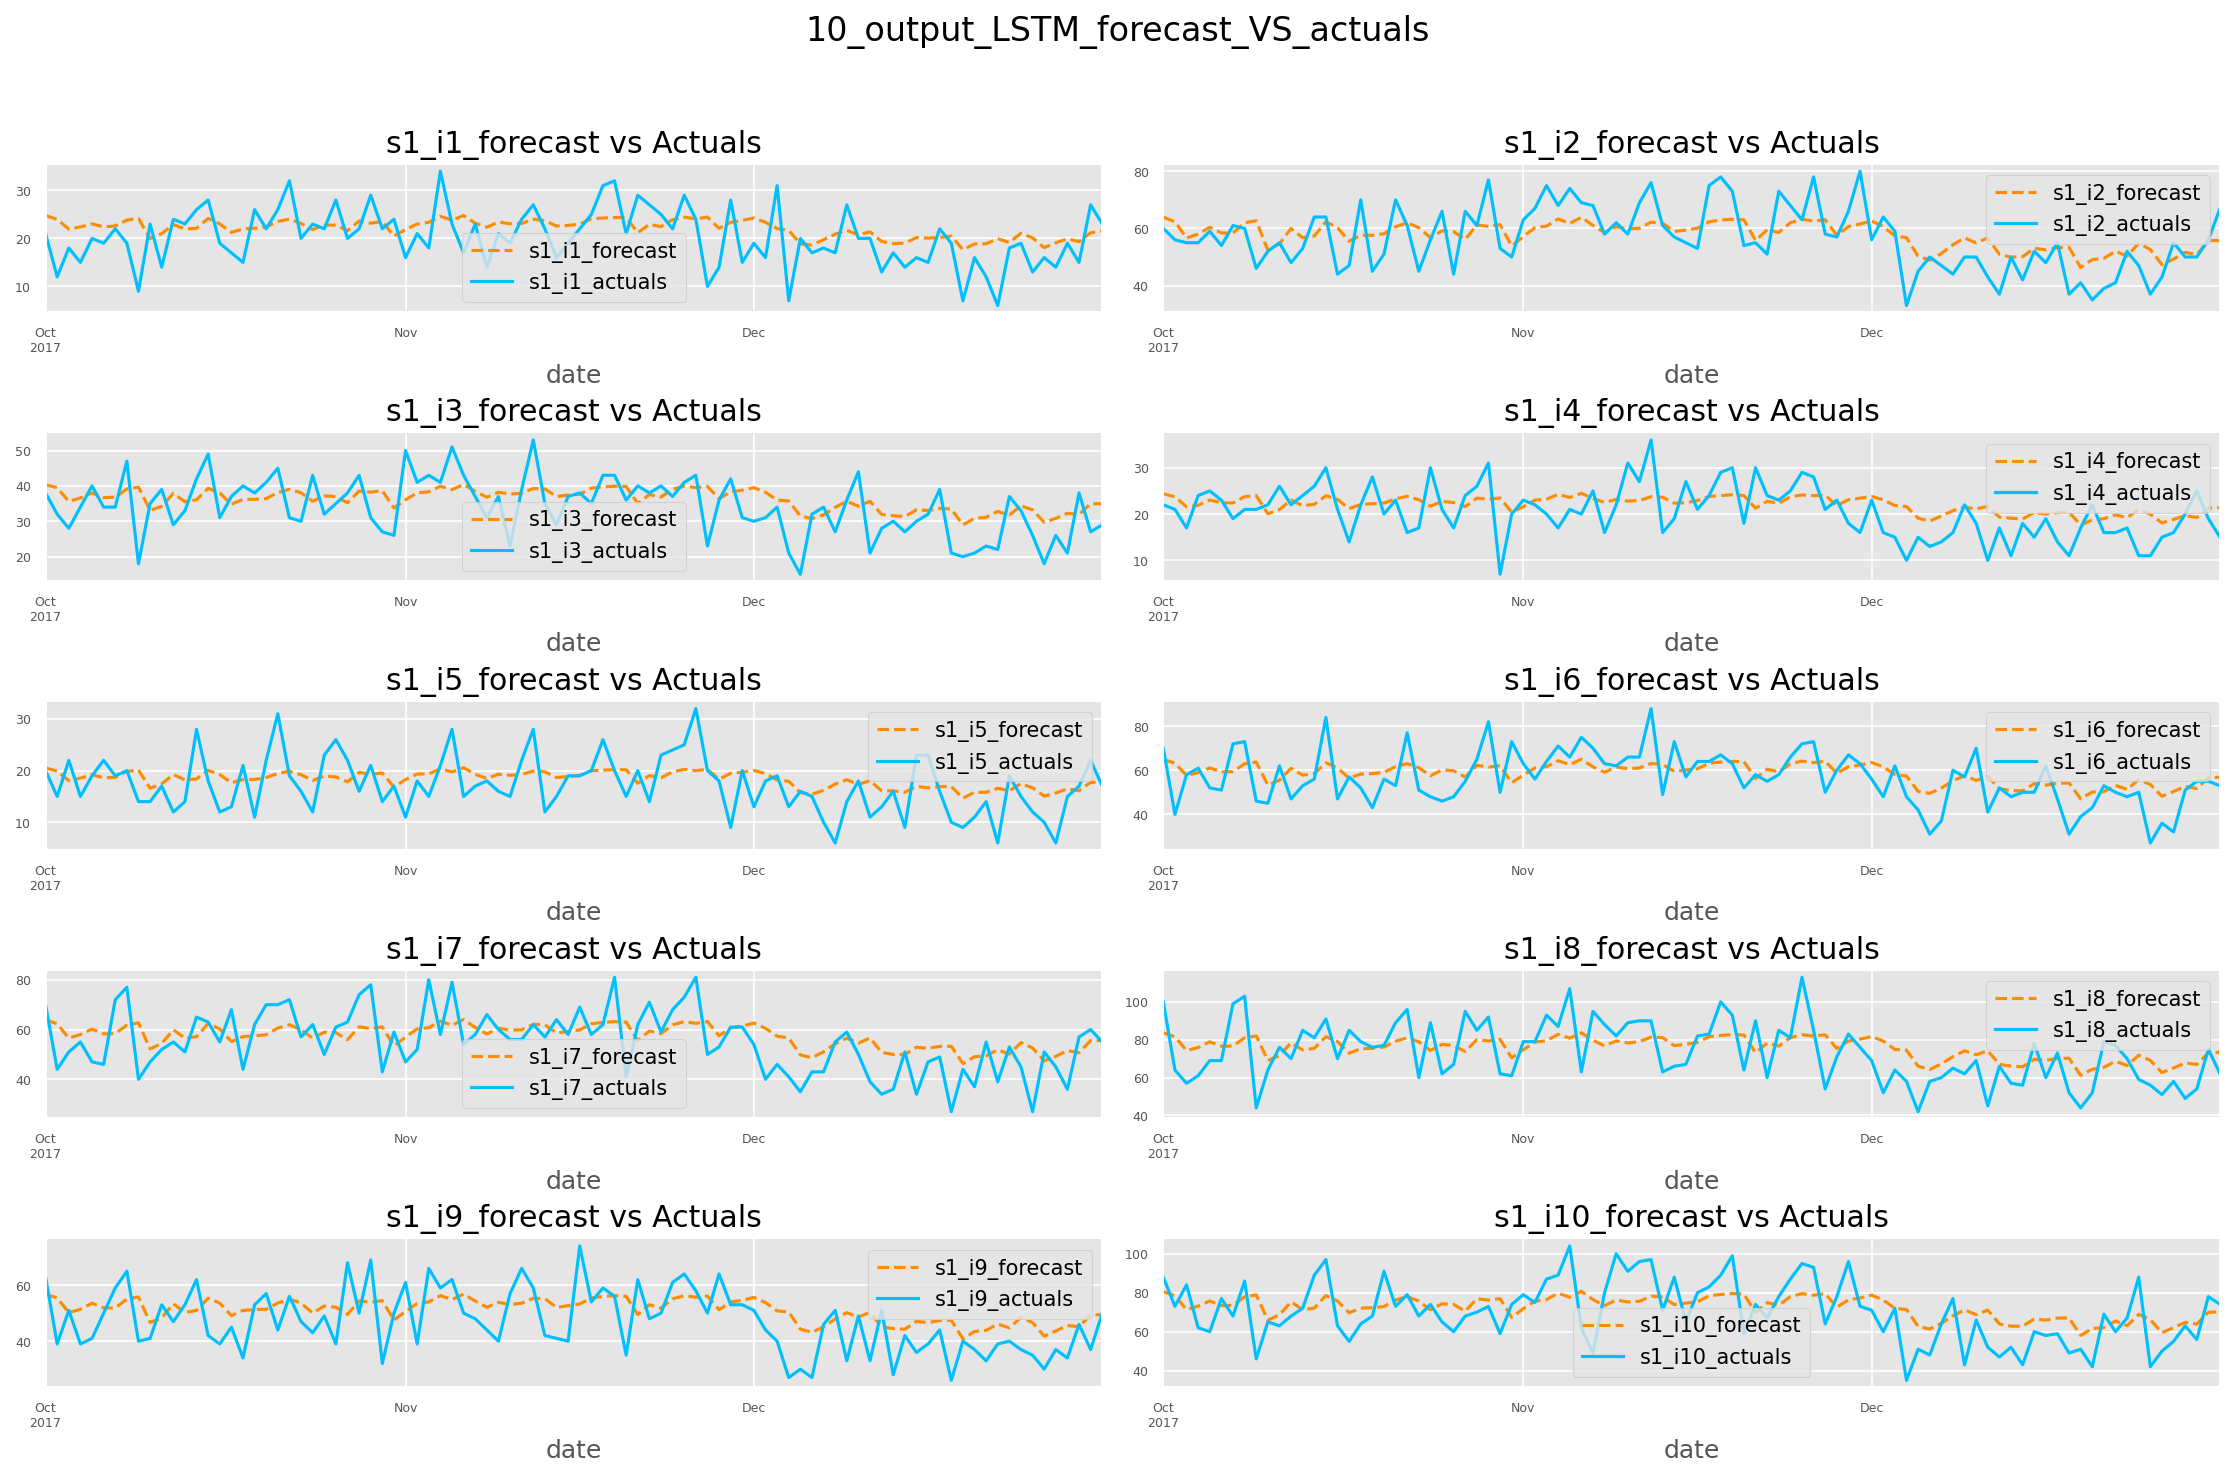

In [66]:
figtitle = '10_output_LSTM_forecast_VS_actuals'
prediction_len =df_forecast.shape[1]
th.plot_results_multiple(df_forecast, valid, prediction_len, figtitle)

In [69]:
RMSE_s1_i1  = th.rmse_calculate(df_forecast.iloc[:,0],valid.iloc[:,0])
print(RMSE_s1_i1)

5.6


In [70]:
RMSE_s1_i2  = th.rmse_calculate(df_forecast.iloc[:,1],valid.iloc[:,1])
print(RMSE_s1_i2)

8.88


In [71]:
RMSE_s1_i3  = th.rmse_calculate(df_forecast.iloc[:,2],valid.iloc[:,2])
print(RMSE_s1_i3)

7.38


### 500 output

##### predict 3 months sales for 500 store-item 

In [74]:
# split into training, validation, and test sets.
output_cols = df.columns.tolist()
output_length =92 # the number days we would like to predict
#time_stepts in LSTM: the recurrent cell gets unrolled to a specified length 
time_steps = 14    #recurrent cell numbers,two weeks

train,test,valid = lh.split_data(df,output_length, time_steps)

In [75]:
print('All shapes are:    (train, ,test, valid,labels)')
print(f'train dataset shape: {train.shape}')
print(f'test dataset shape : {test.shape}')
print(f'valid dataset shape: {valid.shape}')
print(f'labels width       : {len(output_cols)}')

All shapes are:    (train, ,test, valid,labels)
train dataset shape: (1720, 500)
test dataset shape : (106, 500)
valid dataset shape: (92, 500)
labels width       : 500


In [78]:
# Genarate window datasets
# One of the most difficult parts of Deep Learning modelling is to get the dataset in the right format 
# The function completes that process
X_train, y_train = lh.window_generator(train, train.iloc[:,:len(output_cols)],time_steps)
X_test,  y_test  = lh.window_generator(test, test.iloc[:,:len(output_cols)],time_steps)

print('All shapes are: (X_train, y_train, X_test,  y_test)')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test  shape: {X_test.shape}')
print(f'y_test  shape: {y_test.shape}')

All shapes are: (X_train, y_train, X_test,  y_test)
X_train shape: (1706, 14, 500)
y_train shape: (1706, 500)
X_test  shape: (92, 14, 500)
y_test  shape: (92, 500)


In [84]:
# call lstm model
lstm_units = 128*6
model = Sequential()
model.add(LSTM(
            units = lstm_units,
            input_shape=(X_train.shape[1], X_train.shape[2]),
            return_sequences=False
            ))
model.add(Activation("tanh"))
model.add(Dropout(0.2))
model.add(Dense(units=X_train.shape[2]*4))

model.add(Dense(units=X_train.shape[2]*2))
model.add(Dense(units=X_train.shape[2]))
model.compile(
                loss='mse',
                optimizer="rmsprop") 

In [85]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=40,
    validation_split=0.1,
    verbose=1,
    shuffle=False)

Train on 1535 samples, validate on 171 samples
Epoch 1/30
1535/1535 [==============================] - 25s 16ms/sample - loss: 370.0168 - val_loss: 356.1447
Epoch 2/30
1535/1535 [==============================] - 21s 14ms/sample - loss: 239.9306 - val_loss: 353.9206
Epoch 3/30
1535/1535 [==============================] - 21s 14ms/sample - loss: 237.7963 - val_loss: 371.3911
Epoch 4/30
1535/1535 [==============================] - 21s 14ms/sample - loss: 234.0444 - val_loss: 315.2517
Epoch 5/30
1535/1535 [==============================] - 21s 14ms/sample - loss: 245.1544 - val_loss: 347.2093
Epoch 6/30
1535/1535 [==============================] - 21s 14ms/sample - loss: 228.1598 - val_loss: 381.1505
Epoch 7/30
1535/1535 [==============================] - 21s 14ms/sample - loss: 218.8203 - val_loss: 344.7376
Epoch 8/30
1535/1535 [==============================] - 23s 15ms/sample - loss: 222.4316 - val_loss: 350.1777
Epoch 9/30
1535/1535 [==============================] - 22s 14ms/sample -

In [96]:
y_pred = model.predict(X_test)
y_pred.shape

(92, 50)

In [ ]:
df_forecast_500 = pd.DataFrame(y_pred, index=valid.index, columns=valid.columns + '_forecast')
df_forecast_500

In [97]:
df_forecast

,s1_i1_forecast,s1_i2_forecast,s1_i3_forecast,s1_i4_forecast,s1_i5_forecast,s1_i6_forecast,s1_i7_forecast,s1_i8_forecast,s1_i9_forecast,s1_i10_forecast,...,s10_i41_forecast,s10_i42_forecast,s10_i43_forecast,s10_i44_forecast,s10_i45_forecast,s10_i46_forecast,s10_i47_forecast,s10_i48_forecast,s10_i49_forecast,s10_i50_forecast
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,19.230562,51.866211,34.856064,22.66947,15.418495,55.514885,54.124481,70.85791,48.418964,68.701057,...,27.532993,43.683895,61.167248,35.730221,92.911415,68.539284,25.00074,59.316723,33.86137,74.314766
2017-10-02,19.230562,51.866211,34.856064,22.66947,15.418495,55.514885,54.124481,70.85791,48.418964,68.701057,...,27.532993,43.683895,61.167248,35.730221,92.911415,68.539284,25.00074,59.316723,33.86137,74.314766
2017-10-03,19.230562,51.866211,34.856064,22.66947,15.418495,55.514885,54.124481,70.85791,48.418964,68.701057,...,27.532993,43.683895,61.167248,35.730221,92.911415,68.539284,25.00074,59.316723,33.86137,74.314766
2017-10-04,19.230562,51.866211,34.856064,22.66947,15.418495,55.514885,54.124481,70.85791,48.418964,68.701057,...,27.532993,43.683895,61.167248,35.730221,92.911415,68.539284,25.00074,59.316723,33.86137,74.314766
2017-10-05,19.230562,51.866211,34.856064,22.66947,15.418495,55.514885,54.124481,70.85791,48.418964,68.701057,...,27.532993,43.683895,61.167248,35.730221,92.911415,68.539284,25.00074,59.316723,33.86137,74.314766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.230562,51.866211,34.856064,22.66947,15.418495,55.514885,54.124481,70.85791,48.418964,68.701057,...,27.532993,43.683895,61.167248,35.730221,92.911415,68.539284,25.00074,59.316723,33.86137,74.314766
2017-12-28,19.230562,51.866211,34.856064,22.66947,15.418495,55.514885,54.124481,70.85791,48.418964,68.701057,...,27.532993,43.683895,61.167248,35.730221,92.911415,68.539284,25.00074,59.316723,33.86137,74.314766
2017-12-29,19.230562,51.866211,34.856064,22.66947,15.418495,55.514885,54.124481,70.85791,48.418964,68.701057,...,27.532993,43.683895,61.167248,35.730221,92.911415,68.539284,25.00074,59.316723,33.86137,74.314766


In [327]:
RMSE_s1_i1  = th.rmse_calculate(df_forecast.iloc[:,0],valid.iloc[:,0])
print(RMSE_s1_i1)

6.33


In [329]:
RMSE_s1_i2  = th.rmse_calculate(df_forecast.iloc[:,1],valid.iloc[:,1])
print(RMSE_s1_i2)

13.37


In [331]:
RMSE_s1_i3  = th.rmse_calculate(df_forecast.iloc[:,2],valid.iloc[:,2])
print(RMSE_s1_i3)

8.11


In [ ]:
df_forecast_500 = 

In [98]:
df_submmit = pd.concat(df_forecast.iloc[:,i] for i in range(df_forecast.shape[1]))

In [99]:
df_500_submmit =pd.DataFrame(df_submmit,columns=['LSTM_500_forecast'])

In [100]:
df_500_submmit.head()

,LSTM_500_forecast
date,
2017-10-01,19.230562
2017-10-02,19.230562
2017-10-03,19.230562
2017-10-04,19.230562
2017-10-05,19.230562


In [102]:
df_500_submmit.shape

(46000, 1)

In [103]:
df_500_submmit.to_csv('data/LSTM_500_forecast.csv',index =True)

In [104]:
df_500_submmit[92:184]

,LSTM_500_forecast
date,
2017-10-01,51.866211
2017-10-02,51.866211
2017-10-03,51.866211
2017-10-04,51.866211
2017-10-05,51.866211
...,...
2017-12-27,51.866211
2017-12-28,51.866211
2017-12-29,51.866211


### 50 output

In [241]:
# predict 3 months sales for 10 store-item 
df.head()

,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,s1_i10,...,s10_i41,s10_i42,s10_i43,s10_i44,s10_i45,s10_i46,s10_i47,s10_i48,s10_i49,s10_i50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,33,15,10,11,31,25,33,18,37,...,12,20,24,17,45,37,11,25,17,33
2013-01-02,11,43,30,11,6,36,23,37,23,34,...,10,22,29,10,45,33,13,24,13,37
2013-01-03,14,23,14,8,8,18,34,38,25,32,...,17,27,43,20,56,28,16,29,19,46
2013-01-04,13,18,10,19,9,19,36,54,22,45,...,13,24,27,12,50,44,11,39,23,51
2013-01-05,10,34,23,12,8,31,38,51,29,35,...,14,25,31,25,62,45,16,34,22,41


In [88]:
# sampling = random.choices(np.arange(df.shape[1]), k=3)
sampling =np.arange(50)
sampling

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [89]:
df_10 = df.iloc[:,sampling]
df_10.head()

,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,s1_i10,...,s1_i41,s1_i42,s1_i43,s1_i44,s1_i45,s1_i46,s1_i47,s1_i48,s1_i49,s1_i50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,33,15,10,11,31,25,33,18,37,...,6,21,22,20,37,30,17,21,18,30
2013-01-02,11,43,30,11,6,36,23,37,23,34,...,15,24,27,15,40,30,15,26,10,32
2013-01-03,14,23,14,8,8,18,34,38,25,32,...,5,14,19,11,42,30,5,25,17,25
2013-01-04,13,18,10,19,9,19,36,54,22,45,...,9,22,29,22,49,37,13,26,22,32
2013-01-05,10,34,23,12,8,31,38,51,29,35,...,13,18,34,19,52,28,12,28,15,35


In [90]:
# split into training, validation, and test sets.
output_cols = df_10.columns.tolist()
output_length =92 # the number days we would like to predict
#time_stepts in LSTM: the recurrent cell gets unrolled to a specified length 
time_steps = 14    #recurrent cell numbers,two weeks

train,test,valid = lh.split_data(df_10,output_length, time_steps)

In [91]:
print('All shapes are:    (train, ,test, valid,labels)')
print(f'train dataset shape: {train.shape}')
print(f'test dataset shape : {test.shape}')
print(f'valid dataset shape: {valid.shape}')
print(f'labels width       : {len(output_cols)}')

All shapes are:    (train, ,test, valid,labels)
train dataset shape: (1720, 50)
test dataset shape : (106, 50)
valid dataset shape: (92, 50)
labels width       : 50


In [92]:
# Genarate window datasets
# One of the most difficult parts of Deep Learning modelling is to get the dataset in the right format 
# The function completes that process
X_train, y_train = lh.window_generator(train, train.iloc[:,:len(output_cols)],time_steps)
X_test,  y_test  = lh.window_generator(test, test.iloc[:,:len(output_cols)],time_steps)

print('All shapes are: (X_train, y_train, X_test,  y_test)')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test  shape: {X_test.shape}')
print(f'y_test  shape: {y_test.shape}')

All shapes are: (X_train, y_train, X_test,  y_test)
X_train shape: (1706, 14, 50)
y_train shape: (1706, 50)
X_test  shape: (92, 14, 50)
y_test  shape: (92, 50)


In [93]:
# call lstm model
lstm_units = 128*4
model = Sequential()
model.add(LSTM(
            units = lstm_units,
            input_shape=(X_train.shape[1], X_train.shape[2]),
            return_sequences=False
            ))
model.add(Activation("tanh"))
model.add(Dropout(0.2))

model.add(Dense(units=X_train.shape[2]*2))
model.add(Dense(units=X_train.shape[2]))
model.compile(
                loss='mse',
                optimizer="rmsprop") 

In [94]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=30,
    validation_split=0.1,
    verbose=1,
    shuffle=False)

Train on 1535 samples, validate on 171 samples
Epoch 1/30
1535/1535 [==============================] - 13s 8ms/sample - loss: 812.4706 - val_loss: 541.7442
Epoch 2/30
1535/1535 [==============================] - 13s 8ms/sample - loss: 194.0046 - val_loss: 400.4447
Epoch 3/30
1535/1535 [==============================] - 13s 8ms/sample - loss: 191.0534 - val_loss: 395.6556
Epoch 4/30
1535/1535 [==============================] - 12s 8ms/sample - loss: 190.8700 - val_loss: 404.0106
Epoch 5/30
1535/1535 [==============================] - 11s 7ms/sample - loss: 188.2910 - val_loss: 379.6158
Epoch 6/30
1535/1535 [==============================] - 11s 7ms/sample - loss: 186.2783 - val_loss: 374.5206
Epoch 7/30
1535/1535 [==============================] - 11s 7ms/sample - loss: 201.3685 - val_loss: 399.5106
Epoch 8/30
1535/1535 [==============================] - 12s 8ms/sample - loss: 188.4740 - val_loss: 378.1238
Epoch 9/30
1535/1535 [==============================] - 14s 9ms/sample - loss: 18

In [105]:
y_pred = model.predict(X_test)
y_pred.shape

(92, 50)

In [107]:
df_forecast = pd.DataFrame(y_pred, index=valid.index, columns=valid.columns + '_forecast')
df_forecast

,s1_i1_forecast,s1_i2_forecast,s1_i3_forecast,s1_i4_forecast,s1_i5_forecast,s1_i6_forecast,s1_i7_forecast,s1_i8_forecast,s1_i9_forecast,s1_i10_forecast,...,s1_i41_forecast,s1_i42_forecast,s1_i43_forecast,s1_i44_forecast,s1_i45_forecast,s1_i46_forecast,s1_i47_forecast,s1_i48_forecast,s1_i49_forecast,s1_i50_forecast
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,18.889824,52.677708,32.973125,19.662682,15.927236,53.546841,52.622032,69.667763,46.663391,66.568657,...,18.848825,32.810616,46.037548,25.744686,72.859116,52.791954,19.495003,46.645851,26.321995,59.750908
2017-10-02,18.889824,52.677708,32.973125,19.662682,15.927236,53.546841,52.622032,69.667763,46.663391,66.568657,...,18.848825,32.810616,46.037548,25.744686,72.859116,52.791954,19.495003,46.645851,26.321995,59.750908
2017-10-03,18.889824,52.677708,32.973125,19.662682,15.927236,53.546841,52.622032,69.667763,46.663391,66.568657,...,18.848825,32.810616,46.037548,25.744686,72.859116,52.791954,19.495003,46.645851,26.321995,59.750908
2017-10-04,18.889824,52.677708,32.973125,19.662682,15.927236,53.546841,52.622032,69.667763,46.663391,66.568657,...,18.848825,32.810616,46.037548,25.744686,72.859116,52.791954,19.495003,46.645851,26.321995,59.750908
2017-10-05,18.889824,52.677708,32.973125,19.662682,15.927236,53.546841,52.622032,69.667763,46.663391,66.568657,...,18.848825,32.810616,46.037548,25.744686,72.859116,52.791954,19.495003,46.645851,26.321995,59.750908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,18.889824,52.677708,32.973125,19.662682,15.927236,53.546841,52.622032,69.667763,46.663391,66.568657,...,18.848825,32.810616,46.037548,25.744686,72.859116,52.791954,19.495003,46.645851,26.321995,59.750908
2017-12-28,18.889824,52.677708,32.973125,19.662682,15.927236,53.546841,52.622032,69.667763,46.663391,66.568657,...,18.848825,32.810616,46.037548,25.744686,72.859116,52.791954,19.495003,46.645851,26.321995,59.750908
2017-12-29,18.889824,52.677708,32.973125,19.662682,15.927236,53.546841,52.622032,69.667763,46.663391,66.568657,...,18.848825,32.810616,46.037548,25.744686,72.859116,52.791954,19.495003,46.645851,26.321995,59.750908


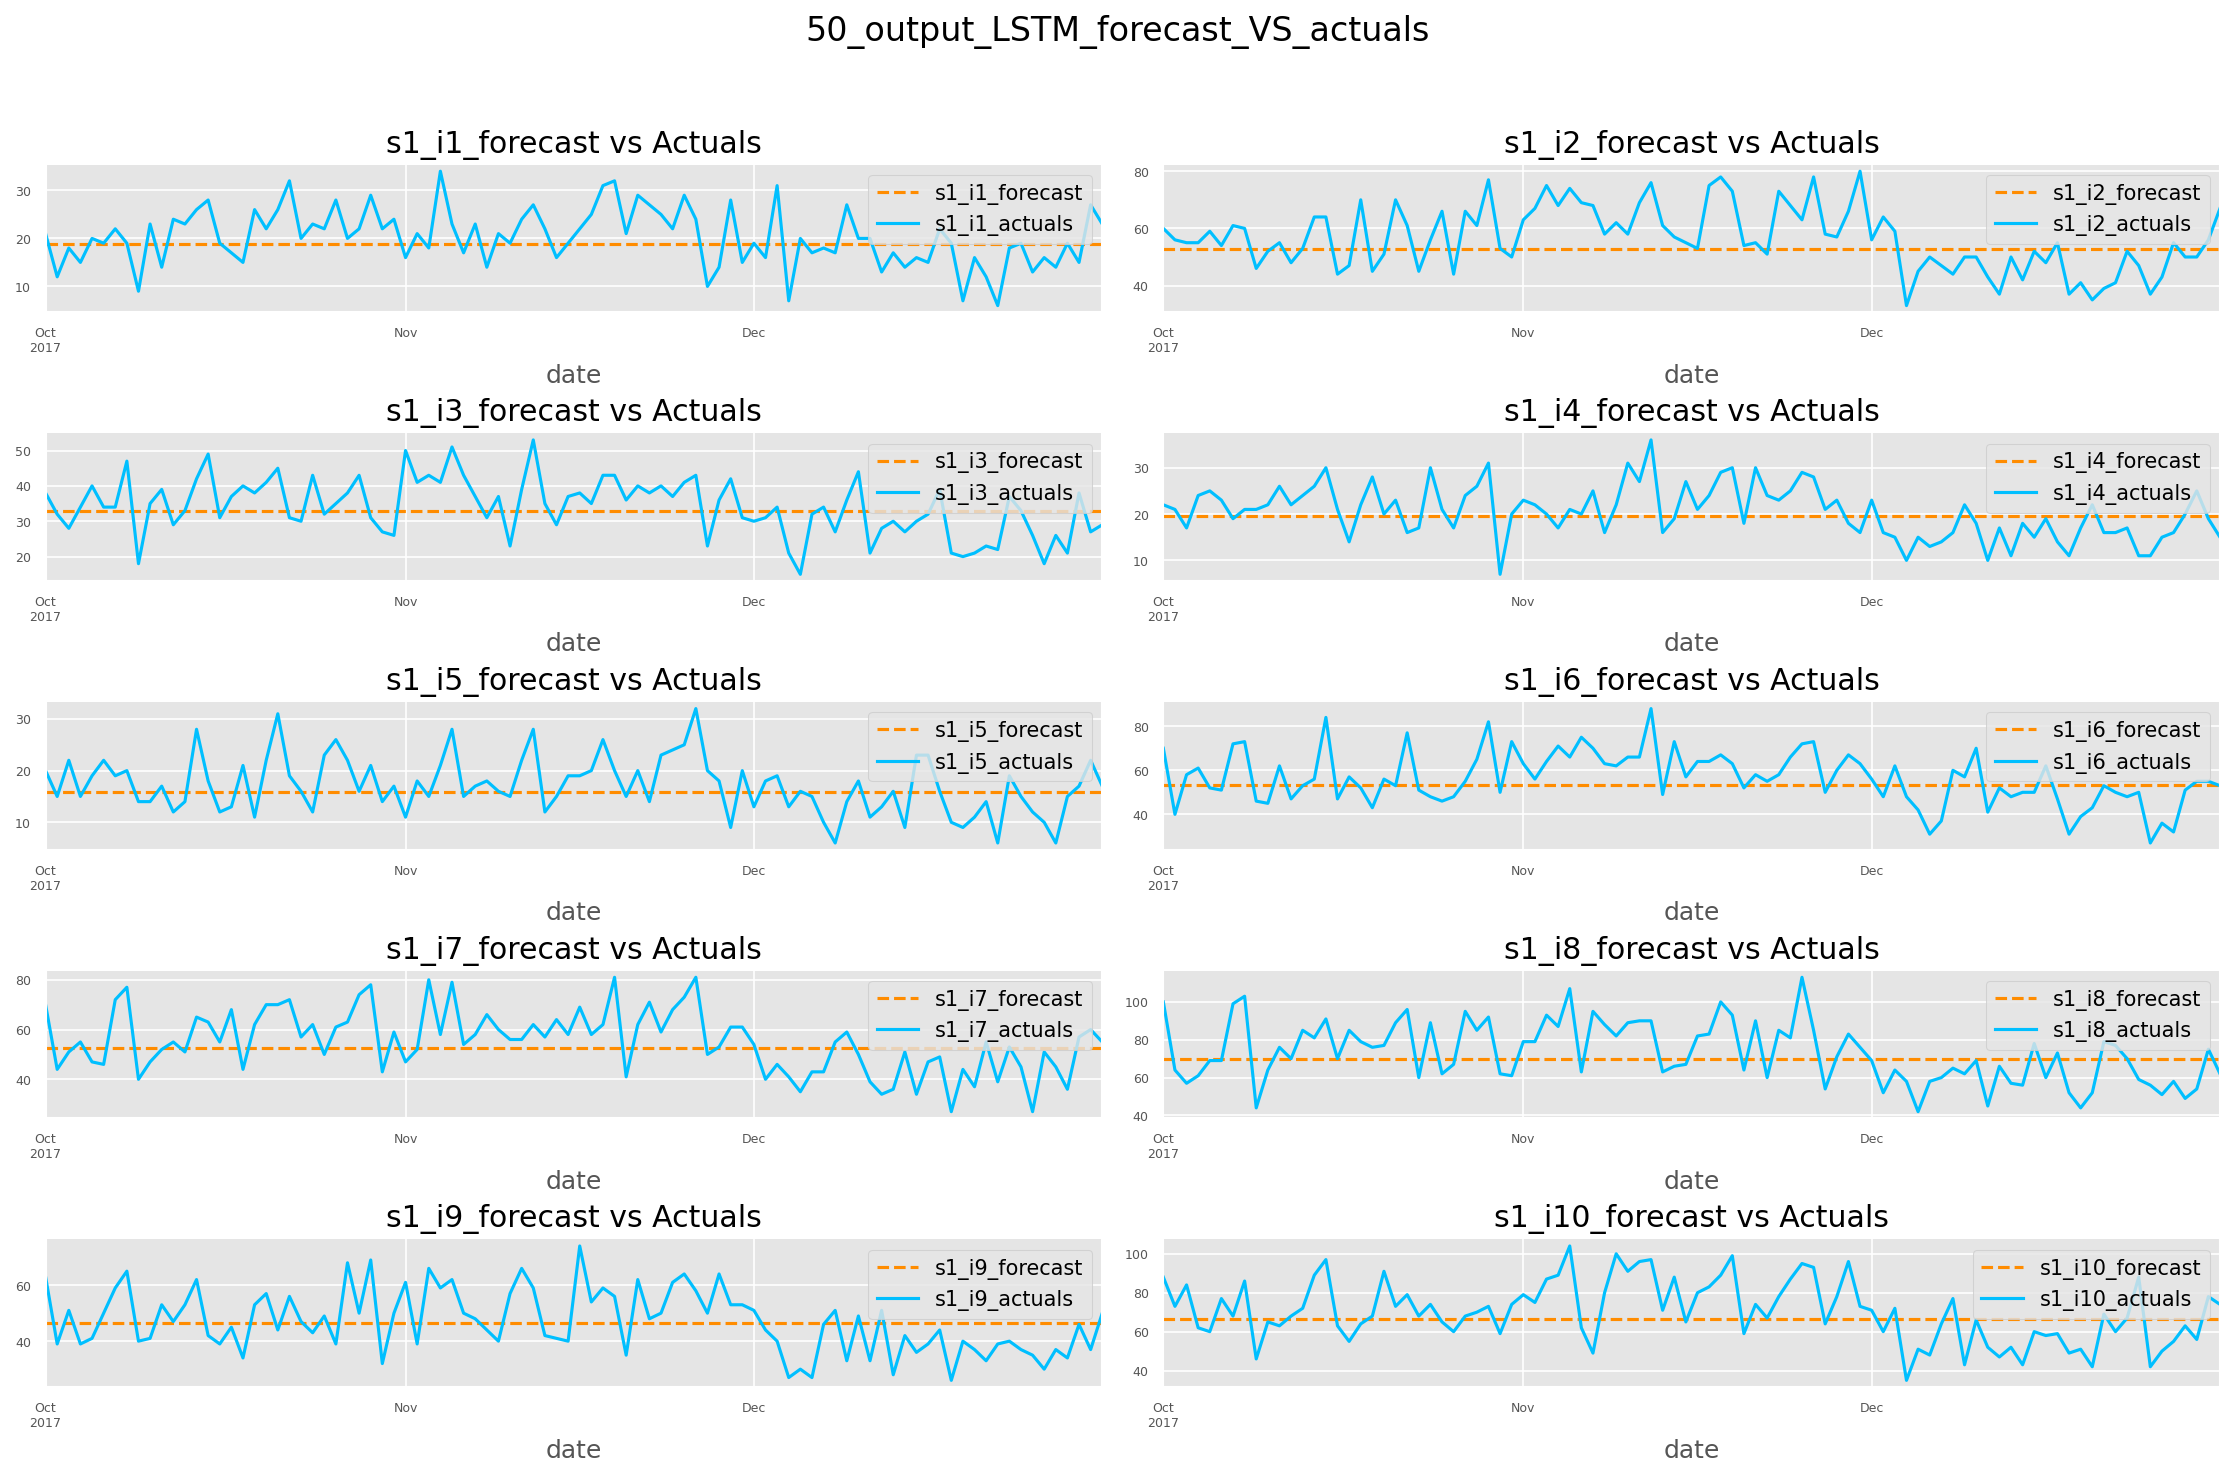

In [116]:
figtitle = '50_output_LSTM_forecast_VS_actuals'
prediction_len =10
th.plot_results_multiple(df_forecast.iloc[:,:10], valid.iloc[:,:10], prediction_len, figtitle)

### 10-output predictions  model
